# 3.4 直方图与傅里叶变换

In [3]:
import cv2  #opencv 读取进来为BGR格式
import matplotlib.pyplot as plt
import numpy as np

#一个魔法指令，不需要采用plt.show()显示图像
%matplotlib inline   

In [4]:
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### 直方图
![title](histogram.png)

(256, 1)
(256,)


<BarContainer object of 256 artists>

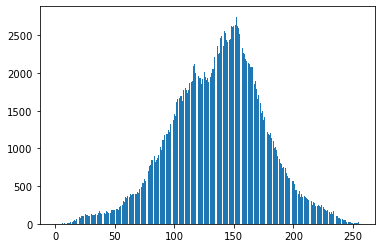

In [6]:
#img = cv2.imread('images/cat.jpg',0) #灰度图像 
img = cv2.imread('images/cat.jpg',cv2.IMREAD_GRAYSCALE)

hist = cv2.calcHist([img],[0],None,[256],[0,256])
print(hist.shape)

#hist = hist.astype(np.int32)
#print(hist)
#hist = np.transpose(hist)
#print(hist.shape)

hist = hist.flatten()
print(hist.shape)

#print(np.arange(256))
#x = np.array([x for x in range(256)]);
#x = np.arange(256).reshape(256,1)
#x = np.transpose(x)
#print(x.shape)

#plt.plot(hist)
plt.bar(np.arange(256),hist)

<BarContainer object of 2 artists>

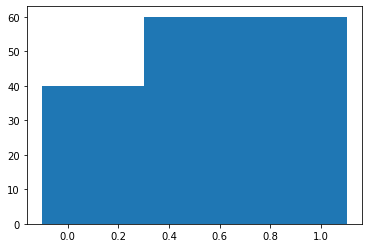

In [43]:
x = [0.7,0.3];
y = [60,40];
plt.bar(x,y)

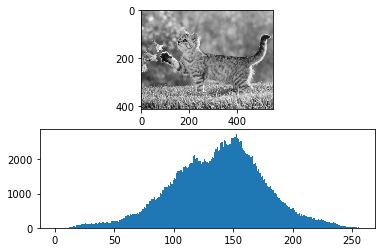

In [19]:
plt.subplot(2,1,1),plt.imshow(img,'gray')
plt.subplot(2,1,2),plt.hist(img.ravel(),256,[0,256]);
plt.show()

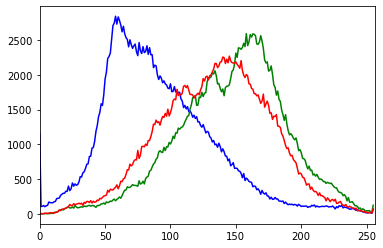

In [24]:
img = cv2.imread('images/cat.jpg')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

### mask操作

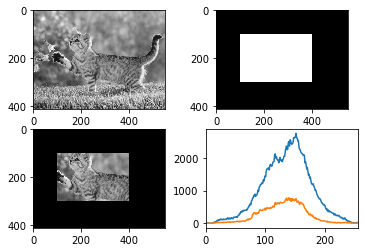

In [55]:
img = cv2.imread('images/cat.jpg',0)

# create a mask
mask = np.zeros(img.shape[:2], np.uint8)


mask[100:300, 100:400] = 255
masked_img = cv2.bitwise_and(img,img,mask = mask)

# 计算掩码区域和非掩码区域的直方图
# 检查作为掩码的第三个参数
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mask,[256],[0,256])
plt.subplot(221), plt.imshow(img, 'gray')
plt.subplot(222), plt.imshow(mask,'gray')
plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

### 直方图均衡化
![title](hist.png)
![title](hist2.png)
![title](hist3.png)

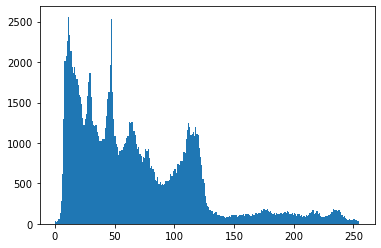

In [10]:
img = cv2.imread('images/clahe.jpg',0)
plt.hist(img.ravel(),256)
plt.show()

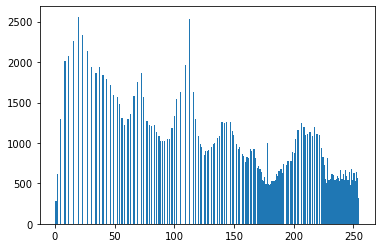

In [11]:
equ = cv2.equalizeHist(img)
plt.hist(equ.ravel(),256)
plt.show()

In [13]:
res = np.hstack((img,equ))

cv_show('res',res)

### 自适应直方图均衡化

In [14]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

cl1 = clahe.apply(img)

res2 = np.hstack((img,equ,cl1))

cv_show('res2',res2)

## 3.4.2 傅里叶变换

#### 我们生活在时间的世界中，早上7:00起来吃饭，8:00去挤地铁，9:00开始上班。。。以时间为参照对应的就是时域分析

#### 但是在频域中一切都是静止的！https://zhuanlan.zhihu.com/p/19763358

### 傅里叶变换的作用
- 高频：变化剧烈的灰度分量，例如边界
- 低频：变化缓慢的灰度分量，例如一片大海

### 滤波
- 低通滤波器：只保留低频，会使得图像模糊
- 高通滤波器：只保留高频，会使得图像细节增强



- opencv中主要就是cv2.dft()和cv2.idft()，输入图像需要先转换成np.float32格式
- 得到的结果中频率为0的部分会在左上角，通常要转换到中心位置，可以通过shift变换来实现
- cv2.dft()返回的结果是双通道的(实部，虚部)，通常还需要转换成图像格式才能展示(0,255)

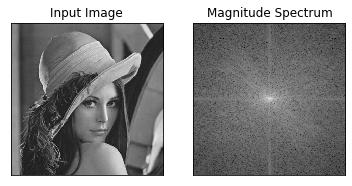

In [71]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/lena.jpg',0)

img_float32 = np.float32(img)

dft = cv2.dft(img_float32,flags = cv2.DFT_COMPLEX_OUTPUT)

dft_shift = np.fft.fftshift(dft)
# 得到灰度图能表示的形式
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

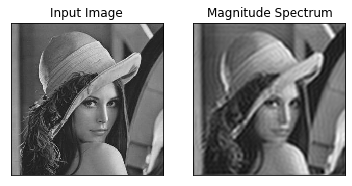

In [74]:
rows, cols = img.shape
crow, ccol = np.int32(rows/2) , np.int32(cols/2)

# 首先创建一个掩码，中心正方形为1，其余全为零(低通滤波器)
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# 应用掩码和逆DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)

img_back = cv2.idft(f_ishift)

img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

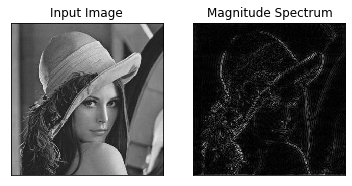

In [75]:
rows, cols = img.shape
crow, ccol = np.int32(rows/2) , np.int32(cols/2)

# 首先创建一个掩码，中心正方形为0，其余全为1(高通滤波器)
mask = np.ones((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 0

# 应用掩码和逆DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)

img_back = cv2.idft(f_ishift)

img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()